In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torchvision.transforms.functional as TF

import random

In [ ]:
from tqdm import tqdm

In [ ]:
def read_data(folder):
    data = np.load(folder + '/data.npy')
    data[data < 0] = 0
    return data

In [ ]:
def cutted_array(data,start, end):
    return data[:, :, start:end]

In [ ]:
class UNET(nn.Module):
    def __init__(self, in_channels=1, classes=1):
        super(UNET, self).__init__()
        self.layers = [in_channels, 32, 64, 128, 256, 512]

        self.double_conv_downs = nn.ModuleList(
            [self.__double_conv(layer, layer_n) for layer, layer_n in zip(self.layers[:-1], self.layers[1:])])

        self.up_trans = nn.ModuleList(
            [nn.ConvTranspose2d(layer, layer_n, kernel_size=2, stride=2)
             for layer, layer_n in zip(self.layers[::-1][:-2], self.layers[::-1][1:-1])])

        self.double_conv_ups = nn.ModuleList(
        [self.__double_conv(layer, layer//2) for layer in self.layers[::-1][:-2]])

        self.max_pool_2x2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.final_conv = nn.Conv2d(32, classes, kernel_size=1)


    def __double_conv(self, in_channels, out_channels):
        conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        return conv

    def forward(self, x):
        # down layers
        concat_layers = []

        for down in self.double_conv_downs:
            x = x.float()
            x = down(x)
            if down != self.double_conv_downs[-1]:
                concat_layers.append(x)
                x = self.max_pool_2x2(x)

        concat_layers = concat_layers[::-1]

        # up layers
        for up_trans, double_conv_up, concat_layer  in zip(self.up_trans, self.double_conv_ups, concat_layers):
            x = up_trans(x)
            if x.shape != concat_layer.shape:
                x = TF.resize(x, concat_layer.shape[2:])

            concatenated = torch.cat((concat_layer, x), dim=1)
            x = double_conv_up(concatenated)

        x = self.final_conv(x)

        return x

In [ ]:
def give_me_masks_from_model(num_array, num_model, data):
    model = UNET(1, 5).to('cuda')
    model.load_state_dict(torch.load('C:/Users/MK/Nika/2D/exp1/hyperparameter0/unet2d' + str(num_model), map_location=torch.device('cuda')))
    model.eval()

    data2 = np.zeros((256, 256, 512))
    for x in range(256):
        data2[x, :, :] = data[:, :, x]
    data_blocks_tensor = torch.FloatTensor(data2)
    out_new = np.zeros((256, 5, 256, 512))
    for i in tqdm(range(256)):
        out_new[i] = model(data_blocks_tensor[i].unsqueeze(0).unsqueeze(0).to('cuda')).detach().cpu()
    masks = np.zeros((5, 256, 512, 256))
    for z in tqdm(range(256)):
        for x in range(256):
            for y in range(512):
                num = np.argmax(out_new[x, :, z, y])
                masks[num, z, y, x] = 1
    np.save('C:/Users/MK/Nika/2D/exp1/hyperparameter0/val/masks_model' + str(num_array) + '_' + str(num_model) + '.npy', masks)

    plt.imshow(data[:, : , 3])
    plt.imshow(masks[2, :, : , 3])

100%|████████████████████████████████████████████████████████████████████████████████| 256/256 [01:16<00:00,  3.34it/s]


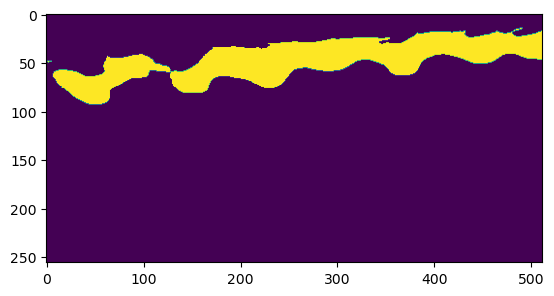

In [ ]:
data = read_data('C:/Users/MK/Nika/размеченные датасеты/finger6')
data = cutted_array(data, 60, 60+256)
for ind_model in range(1,5):
    give_me_masks_from_model(6, ind_model, data)


data = read_data('C:/Users/MK/Nika/размеченные датасеты/finger5')
data = cutted_array(data, 156, 156+256)
for ind_model in range(0,5):
    give_me_masks_from_model(5, ind_model, data)